In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline

In [22]:
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

In [23]:
train = pd.read_csv(r"C:\Users\minha\Downloads\archive (1)\train.csv")
features = pd.read_csv(r"C:\Users\minha\Downloads\archive (1)\features.csv")
stores = pd.read_csv(r"C:\Users\minha\Downloads\archive (1)\stores.csv")

In [24]:
train = train.merge(features, on=["Store", "Date"], how="left")
train = train.merge(stores, on="Store", how="left")

In [25]:
train["Date"] = pd.to_datetime(train["Date"])
train = train.sort_values(["Store", "Date"]).reset_index(drop=True)

In [26]:
print(train.shape)
train.head()

(421570, 17)


,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [27]:
train["Year"] = train["Date"].dt.year
train["Month"] = train["Date"].dt.month
train["Week"] = train["Date"].dt.isocalendar().week.astype(int)
train["Day"] = train["Date"].dt.day

In [28]:
train["rolling_7"] = train.groupby("Store")["Weekly_Sales"].transform(lambda x: x.rolling(7).mean())
train["rolling_14"] = train.groupby("Store")["Weekly_Sales"].transform(lambda x: x.rolling(14).mean())
train["rolling_30"] = train.groupby("Store")["Weekly_Sales"].transform(lambda x: x.rolling(30).mean())

In [29]:
train[["rolling_7", "rolling_14", "rolling_30"]] = train[["rolling_7", "rolling_14", "rolling_30"]].fillna(method='bfill')

C:\Users\minha\AppData\Local\Temp\ipykernel_11000\2036160944.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train[["rolling_7", "rolling_14", "rolling_30"]] = train[["rolling_7", "rolling_14", "rolling_30"]].fillna(method='bfill')


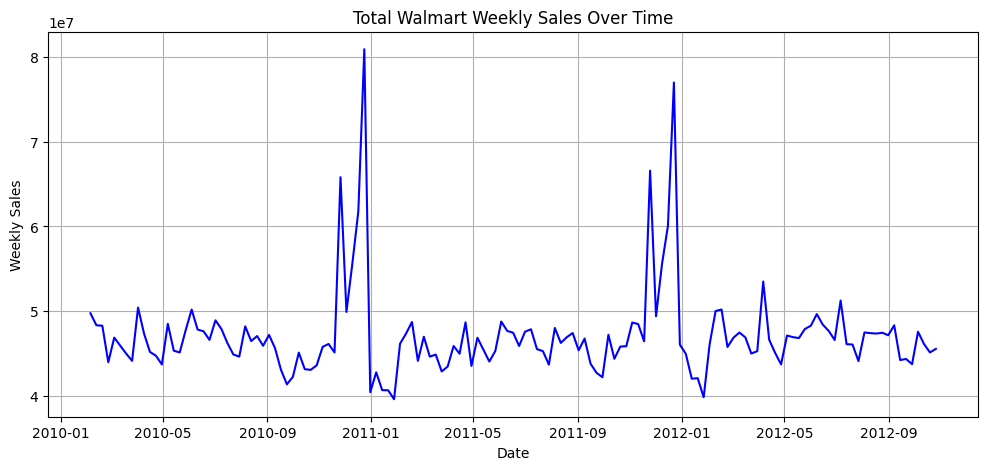

In [30]:
daily_sales = train.groupby("Date")["Weekly_Sales"].sum()

plt.figure(figsize=(12, 5))
plt.plot(daily_sales.index, daily_sales.values, color='blue')
plt.title("Total Walmart Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.grid(True)
plt.show()

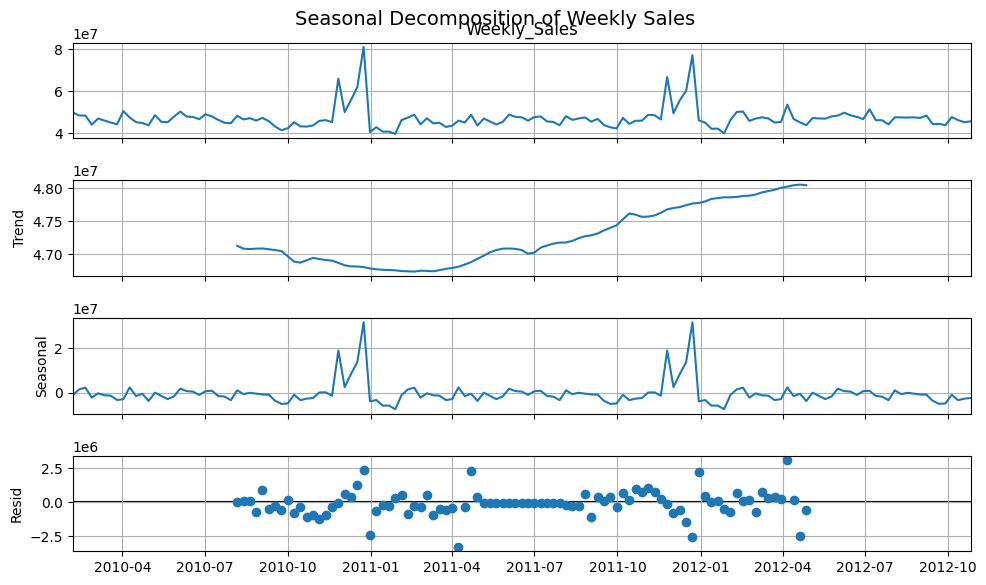

In [31]:
decomposition = seasonal_decompose(daily_sales, model='additive', period=52)  # Weekly data → 52 weeks
fig = decomposition.plot()
fig.set_size_inches(10, 6)
plt.suptitle('Seasonal Decomposition of Weekly Sales', fontsize=14)
plt.show()

In [32]:
x = train.drop(columns=["Weekly_Sales", "Date"])
y = train["Weekly_Sales"]

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [35]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Random Forest RMSE: {rmse_rf:.2f}")

Random Forest RMSE: 20143.98


In [41]:
xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [42]:
y_pred_xgb = xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"XGBoost RMSE: {rmse_xgb:.2f}")

XGBoost RMSE: 21113.34


In [43]:
print(f"Random Forest R2: {r2_score(y_test, y_pred_rf):.4f}")
print(f"XGBoost R2: {r2_score(y_test, y_pred_xgb):.4f}")

Random Forest R2: 0.2282
XGBoost R2: 0.1521


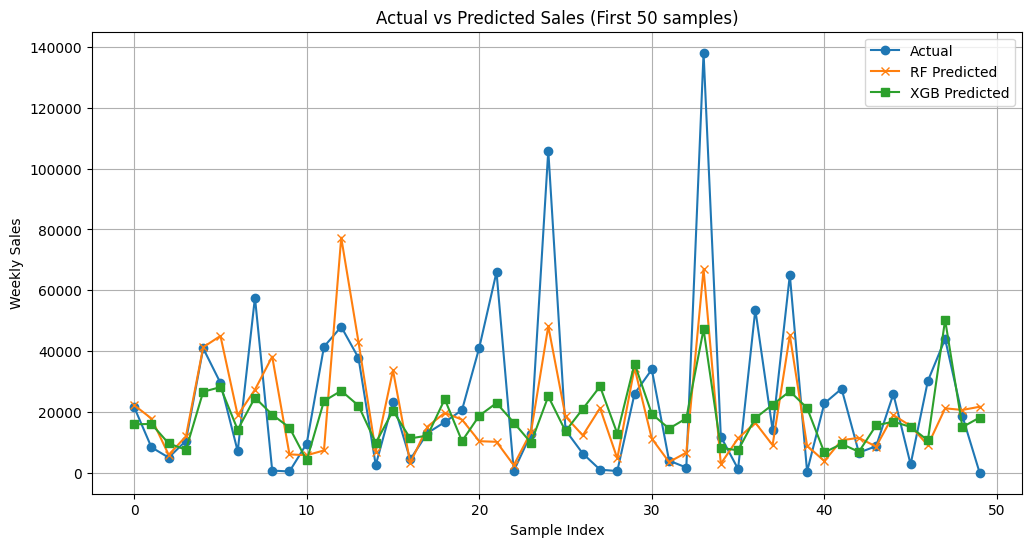

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:50], label='Actual', marker='o')
plt.plot(y_pred_rf[:50], label='RF Predicted', marker='x')
plt.plot(y_pred_xgb[:50], label='XGB Predicted', marker='s')
plt.title("Actual vs Predicted Sales (First 50 samples)")
plt.xlabel("Sample Index")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()

In [45]:
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MSE: 943097977.4672841
R2 Score: -0.7938994846002623


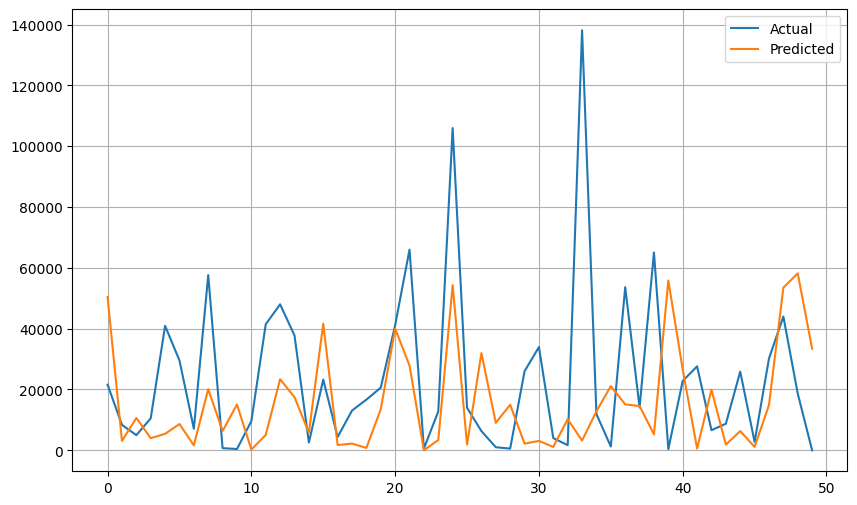

In [46]:
plt.figure(figsize=(10,6))
plt.plot(y_test.values[:50], label='Actual')
plt.plot(y_pred[:50], label='Predicted')
plt.legend()
plt.show()